In [104]:
import tensorflow_datasets as tfds
import numpy as np


import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
#import matplotlib.pyplot as plt
#ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [6]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Dataset imdb_reviews downloaded and prepared to /home/anca/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


In [7]:
encoder = info.features['text'].encoder

print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [23]:
info, info.splits['train'].num_examples

(tfds.core.DatasetInfo(
     name='imdb_reviews',
     version=0.1.0,
     description='Large Movie Review Dataset.
 This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
     urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
     features=FeaturesDict({
         'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
         'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
     }),
     total_num_examples=100000,
     splits={
         'test': 25000,
         'train': 25000,
         'unsupervised': 50000,
     },
     supervised_keys=('text', 'label'),
     citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
       author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, An

In [8]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  12 1167 7968   21  165   14   32   11  255   55]
Label: 1


In [14]:
encoder.decode(train_example)

'I haven\'t seen this film in years so my knowledge is a little rusty. I do remember thinking that this film is twice the film of Braveheart. It is simply more realistic and has more believable characters. Ridb Roy looks like one would imagine Rob Roy to look like, messy hair and beard with simple clothing. Also the Liam Nesson has a Celtic look about him, he looks like a Scot and more importantly looks like Rob Roy. It\'s a comparison which angers some people but compare him to Mel Gibson as William Wallace. Gibson is supposedly playing a man who\'s legend has caused him to be described as a 6 foot 7 giant while Gibson is almost a foot shorter. The story contains a little romance, conspiracy and an underdog story. Sound anything like Braveheart? But instead of a film that cries out "freedom", liberty and nationalism we get a film which says honour, love and justice. This makes it a more interesting film. Much like Gladiator. The cast is fantastic and Liam Nesson is a very strong leade

In [33]:

for (x,y) in tfds.as_numpy(train_data.take(2)): #remove take(2)
    print(x.shape, y)

(194,) 1
(177,) 1


In [80]:
#vectorize x
def vectorize_sequences(number_of_examples, dimension, data):
    results = np.zeros((number_of_examples, dimension ))
    labels = np.zeros((number_of_examples))
    for i, (x,y) in enumerate(tfds.as_numpy(data)): 
        results[i, x] = 1.  # set specific indices of results[i] to 1s
        labels[i]=int(y)
    return (results, labels)
#vectorize train data
(x_train, y_train) = vectorize_sequences(info.splits['train'].num_examples, encoder.vocab_size, train_data)
(x_test, y_test) = vectorize_sequences(info.splits['test'].num_examples, encoder.vocab_size, test_data)

print(y_train.shape)
#see the values
for i,i1 in zip(x_train[0:1], x_test[0:1]):
    for j,j1 in zip(i,i1):
        print(j, j1)


(25000,)
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 0.0
1.0 0.0
1.0 1.0
1.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 1.0
1.0 0.0
1.0 0.0
1.0 1.0
0.0 1.0
1.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 1.0
1.0 0.0
1.0 1.0
0.0 0.0
1.0 0.0
0.0 0.0
1.0 1.0
1.0 0.0
1.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 1.0
1.0 0.0
0.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 0.0
1.0 1.0
1.0 1.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 1.0

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [138]:
a=np.array([2,1,3,4,0, 10])
a[[2,4,5]]=1
a
import pathlib
import os
logdir = pathlib.Path("../tensorboard_logs/overfit_and_underfit")
if not logdir.exists():
    os.makedirs(logdir)
name='default'

In [170]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='default'
history= model.fit(x_train, y_train, epochs=10, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 106us/sample - loss: 0.5492 - accuracy: 0.7457 - val_loss: 0.4027 - val_accuracy: 0.8623
Epoch 2/10
25000/25000 [==============================] - 2s 91us/sample - loss: 0.2968 - accuracy: 0.9007 - val_loss: 0.3003 - val_accuracy: 0.8812
Epoch 3/10
25000/25000 [==============================] - 2s 86us/sample - loss: 0.2058 - accuracy: 0.9264 - val_loss: 0.3034 - val_accuracy: 0.8768
Epoch 4/10
25000/25000 [==============================] - 2s 95us/sample - loss: 0.1620 - accuracy: 0.9431 - val_loss: 0.3295 - val_accuracy: 0.8711
Epoch 5/10
25000/25000 [==============================] - 2s 90us/sample - loss: 0.1313 - accuracy: 0.9564 - val_loss: 0.3669 - val_accuracy: 0.8644
Epoch 6/10
25000/25000 [==============================] - 2s 85us/sample - loss: 0.1083 - accuracy: 0.9640 - val_loss: 0.4028 - val_accuracy: 0.8616
Epoch 7/10
25000/25000 [==============================]

In [171]:
#smaller
model = keras.Sequential([
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='smaller'
smaller_history= model.fit(x_train, y_train, epochs=10, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 92us/sample - loss: 0.6417 - accuracy: 0.6599 - val_loss: 0.5844 - val_accuracy: 0.7203
Epoch 2/10
25000/25000 [==============================] - 2s 65us/sample - loss: 0.5324 - accuracy: 0.8068 - val_loss: 0.5205 - val_accuracy: 0.8168
Epoch 3/10
25000/25000 [==============================] - 2s 71us/sample - loss: 0.4748 - accuracy: 0.8604 - val_loss: 0.4862 - val_accuracy: 0.8334
Epoch 4/10
25000/25000 [==============================] - 2s 66us/sample - loss: 0.3541 - accuracy: 0.9060 - val_loss: 0.3384 - val_accuracy: 0.8773
Epoch 5/10
25000/25000 [==============================] - 2s 78us/sample - loss: 0.2491 - accuracy: 0.9248 - val_loss: 0.3061 - val_accuracy: 0.8790
Epoch 6/10
25000/25000 [==============================] - 2s 72us/sample - loss: 0.2063 - accuracy: 0.9323 - val_loss: 0.2976 - val_accuracy: 0.8794
Epoch 7/10
25000/25000 [==============================] 

In [172]:
#huge
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='smaller'
huge_history= model.fit(x_train, y_train, epochs=10, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 15s 586us/sample - loss: 0.3919 - accuracy: 0.8234 - val_loss: 0.2975 - val_accuracy: 0.8772
Epoch 2/10
25000/25000 [==============================] - 14s 555us/sample - loss: 0.1560 - accuracy: 0.9427 - val_loss: 0.3257 - val_accuracy: 0.8706
Epoch 3/10
25000/25000 [==============================] - 14s 566us/sample - loss: 0.0402 - accuracy: 0.9896 - val_loss: 0.4701 - val_accuracy: 0.8633
Epoch 4/10
25000/25000 [==============================] - 15s 585us/sample - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.6189 - val_accuracy: 0.8585
Epoch 5/10
25000/25000 [==============================] - 14s 557us/sample - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.6995 - val_accuracy: 0.8641
Epoch 6/10
25000/25000 [==============================] - 14s 571us/sample - loss: 8.1023e-04 - accuracy: 0.9998 - val_loss: 0.7235 - val_accuracy: 0.8652
Epoch 7/10
25000/25000 [================

In [178]:
#regularization
#l2(0.001 ) every coef in weight matrix will add 0.001*weight_coef_value to the total loss of the network
#square of the value of the weight coeffs
#l1 - absolute value of the weight coeffs
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='smaller'
reg_history= model.fit(x_train, y_train, epochs=10, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 115us/sample - loss: 0.5780 - accuracy: 0.7616 - val_loss: 0.4264 - val_accuracy: 0.8688
Epoch 2/10
25000/25000 [==============================] - 2s 88us/sample - loss: 0.3402 - accuracy: 0.9023 - val_loss: 0.3559 - val_accuracy: 0.8817
Epoch 3/10
25000/25000 [==============================] - 2s 93us/sample - loss: 0.2766 - accuracy: 0.9214 - val_loss: 0.3589 - val_accuracy: 0.8790
Epoch 4/10
25000/25000 [==============================] - 2s 87us/sample - loss: 0.2452 - accuracy: 0.9355 - val_loss: 0.3657 - val_accuracy: 0.8778
Epoch 5/10
25000/25000 [==============================] - 2s 88us/sample - loss: 0.2269 - accuracy: 0.9417 - val_loss: 0.3821 - val_accuracy: 0.8711
Epoch 6/10
25000/25000 [==============================] - 2s 90us/sample - loss: 0.2150 - accuracy: 0.9471 - val_loss: 0.4012 - val_accuracy: 0.8667
Epoch 7/10
25000/25000 [==============================]

In [183]:
#dropout

model = keras.Sequential([
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='smaller'
dopout_history= model.fit(x_train, y_train, epochs=10, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 133us/sample - loss: 0.6441 - accuracy: 0.6160 - val_loss: 0.5291 - val_accuracy: 0.8230
Epoch 2/10
25000/25000 [==============================] - 2s 82us/sample - loss: 0.5011 - accuracy: 0.7734 - val_loss: 0.3848 - val_accuracy: 0.8702
Epoch 3/10
25000/25000 [==============================] - 2s 84us/sample - loss: 0.3964 - accuracy: 0.8472 - val_loss: 0.3200 - val_accuracy: 0.8775
Epoch 4/10
25000/25000 [==============================] - 2s 91us/sample - loss: 0.3258 - accuracy: 0.8876 - val_loss: 0.2986 - val_accuracy: 0.8798
Epoch 5/10
25000/25000 [==============================] - 2s 86us/sample - loss: 0.2736 - accuracy: 0.9101 - val_loss: 0.2965 - val_accuracy: 0.8800
Epoch 6/10
25000/25000 [==============================] - 2s 79us/sample - loss: 0.2400 - accuracy: 0.9256 - val_loss: 0.2964 - val_accuracy: 0.8779
Epoch 7/10
25000/25000 [==============================]

In [156]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.140449,0.95376,0.342492,0.86588,5
6,0.128532,0.95884,0.354818,0.86748,6
7,0.115297,0.96384,0.368741,0.86400,7
8,0.105157,0.96824,0.388091,0.86272,8
9,0.096353,0.97220,0.411010,0.85720,9


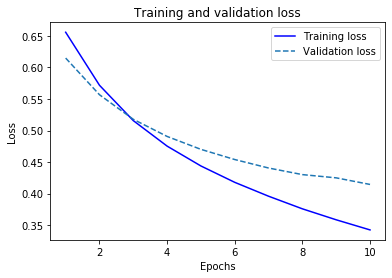

In [164]:
import matplotlib.pyplot as plt

loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

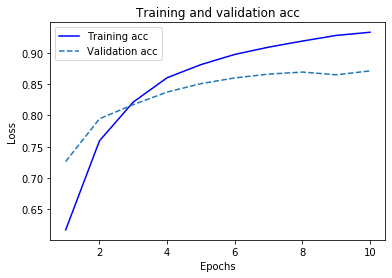

In [166]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, '--', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

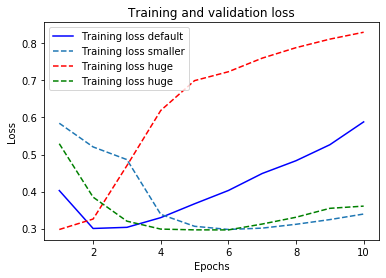

In [184]:
loss_default = history.history['val_loss']
loss_small = smaller_history.history['val_loss']
loss_huge = huge_history.history['val_loss']

loss_reg = reg_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_default, 'b', label='Training loss default')
plt.plot(epochs, loss_small, '--', label='Training loss smaller')
plt.plot(epochs, loss_huge, 'r--', label='Training loss huge')
plt.plot(epochs, loss_reg, 'g--', label='Training loss huge')
plt.plot(epochs, loss_dropout, 'g--', label='Training loss dropout')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()